# Core
> fastai and Huggingface transformers

Documentation of the core functionalities using sequence classification as an example

In [ ]:
# hide
from nbdev.showdoc import show_doc

In [ ]:
# default_exp core
# export
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from fastai.text.all import *
from fastai.data.all import TransformBlock

In [ ]:
pretrained_weights = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
model = AutoModelForSequenceClassification

In [ ]:
df = pd.read_csv('test_data.csv')

In [ ]:
# export
class TransformersTokenizer(Transform):
    """A wrapper for the tokenizer from Huggingface transformers
    Arguments: 
        tokenizer: the tokenizer class from Hugginface transformers
        seq_len: the max length ot the sequences
        truncation: if the sequences exceeding seq_len should be truncated 
                    (should be true if seq_len is provided)
    """
    def __init__(self, tokenizer, seq_len, truncation): 
        # not all tokenizers require seq_len and trncation as arguments
        # and will throw a warning if they do. The problem is, that those 
        # tokenizers also seem to get stuck in an endless  loop if they get 
        # passed these argumtens. I tried a lot, but I found no sophisticated 
        # way to catch the warning. However, those seem to already return  
        # ids (converted to str) instead of str tokens, so this way one might
        # recognize them
        
        self.tokenizer = tokenizer
        self.tokenize = self.tokenizer.tokenize
        x = self.tokenize('Tokenize a text, to see if it already returns ids instead of tokens')
        
        if not self.is_int_as_str(x):     
            self.tokenize = partial(self.tokenizer.tokenize, 
                                max_length=seq_len, 
                                truncation=truncation)
            
    def encodes(self, x:str):
        toks = self.tokenize(x)
        ids = tensor(self.tokenizer.convert_tokens_to_ids(toks)) 
        return TensorText(ids)
    
    def decodes(self, x:TensorText): 
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))
    
    def is_int_as_str(self, x):
        try: 
            int(x[0])
            return True
        except:
            return False

In [ ]:
# export
class TextBlockWithCustomTokenizer(TransformBlock):
    "a TransformBlock with custom Tokenizer from Hugginface transformers"
    def __init__(self, tok, is_lm, seq_len, backwards=False, **kwargs):
        truncation = True if seq_len else None
        type_tfms = [TransformersTokenizer(tok, seq_len, truncation, **kwargs)]
        if backwards: type_tfms += [reverse_text]
        return super().__init__(type_tfms=type_tfms,
                                dl_type=LMDataLoader if is_lm else SortedDL,
                                dls_kwargs={'seq_len': seq_len} if is_lm else {'before_batch': Pad_Chunk(seq_len=seq_len)})

In [ ]:
# export
@patch(cls_method=True)
@delegates(DataLoaders.from_dblock)
def from_df_with_custom_tok(cls:TextDataLoaders, df, path='.', valid_pct=0.2, seed=None, text_col=0, label_col=1, 
                            label_delim=None, y_block=None, is_lm=False, valid_col=None, custom_tok=None, seq_len=72, 
                            backwards=False, **kwargs):
    "Create from `df` in `path` with `valid_pct` and custom tokenizer"
    blocks = [TextBlockWithCustomTokenizer(custom_tok, is_lm, seq_len, backwards)]
    if y_block is None and not is_lm:
        blocks.append(MultiCategoryBlock if is_listy(label_col) and len(label_col) > 1 else CategoryBlock)
    if y_block is not None and not is_lm: blocks += (y_block if is_listy(y_block) else [y_block])
    splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
    dblock = DataBlock(blocks=blocks,
                       get_x=ColReader("text"),
                       get_y=None if is_lm else ColReader(label_col, label_delim=label_delim),
                       splitter=splitter)
    return cls.from_dblock(dblock, df, path=path, seq_len=seq_len, **kwargs)

In [ ]:
dls = TextDataLoaders.from_df_with_custom_tok(df, custom_tok = tokenizer, bs = 8)

In [ ]:
dls.show_batch(max_n = 2)

,text,category
0,"yes, i was lucky enough to see the long - running original production of michael bennett's hit musical. it was an amazing experience and i paid to see the movie when it hit theatres back in 1985. it is awful. almost everything fails. first off, attenborough ( a fine actor, a good director with the right material ) is a sorry",neg
1,"i thought the film could be a bit more complex, in a psychological sense perhaps, but the action and voice acting were top notch. the animation was heavy cg in many scenes, but very good ones at that. this is one of the batman returns / forever type films, which include romances and the conflicts of wayne and motives for dating. 007",pos


In [ ]:
# export
class DropOutput(Callback):
    "Drops some of the output form the transformes model, which is not needed for fastai"
    def after_pred(self): self.learn.pred = self.pred['logits']      

In [ ]:
# export
def create_transformer_classification_model(model, n_out, model_name):
    "creates a classification model from hugginface transformers"
    if model_name:
            # try loading the model wiht custom number of classes, fails for some pretrained models
        try: 
            model = model.from_pretrained(model_name, num_labels = n_out)
        # if above fails, force a new classifiert onto the model
        except: 
            model = model.from_pretrained(model_name)
            last_layer = model.classifier
            if not last_layer.out_features == n_out: 
                warn('Randomly initializing the last layer of the model, as the requested number of classes '
                     'did not match the number of classes specified in the models config file. '
                     'You should probably TRAIN this model on a down-stream task to be able to use it for '
                     'predictions and inference.')
                model.classifier = nn.Linear(last_layer.in_features, n_out)
    else: 
        config = model.config_class()
        config.num_labels = n_out
        model = model(config = config)
    return model

In [ ]:
# export
@delegates(Learner.__init__)
def transformers_classifier_learner(dls, arch, seq_len=72,backwards=False, model_name=None, 
                                    n_out=None, y_range=None, cbs=None, loss_func=None, **kwargs):
    "creates a Learner class for classification using Huggingface transformers"
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = create_transformer_classification_model(model=arch, n_out=n_out, model_name=model_name)
    assert seq_len <= model.config.max_position_embeddings, 'seq_len exceeds the max numbers of embeddings for this model'
    if not isinstance(cbs, list): cbs = [] if cbs is None else [cbs]
    cbs.append(DropOutput())
    learn = Learner(dls, model, loss_func = CrossEntropyLossFlat() if loss_func is None else loss_func, cbs=cbs, **kwargs)
    if model_name: learn.freeze()
    return learn

In [ ]:
# export
@patch
def print_multilabel_classification_report(self:ClassificationInterpretation):
    "Calculates common classification metrics for each label separately."
    def accuracy(x, y): return (x == y).float().mean().numpy()
    target_name = [str(v) for v in self.vocab]
    metrics = [accuracy, RocAuc(), F1Score(), Recall(), Precision(), Jaccard(), MatthewsCorrCoef()]
    res = pd.DataFrame({'metrics': ['accuracy', *[x.name for x in metrics[1:]]]})
    for d,t,n in zip(torch.unbind(self.decoded,1), torch.unbind(self.targs, 1), target_name):
        res[n] = [metric(d if metric=='roc_auc_score' else d.sigmoid().round(),t) for metric in metrics]
    res_t = res.T
    res_t.columns = list(res_t.iloc[0, :])
    return res_t[1:]

In [ ]:
# cuda
learn = transformers_classifier_learner(dls, model, 
                                        model_name=pretrained_weights, 
                                        metrics = accuracy, 
                                        cbs = [SaveModelCallback(), EarlyStoppingCallback(patience=5)]).to_fp16()
learn.unfreeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# cuda
learn.fit_one_cycle(3, 1e-4, wd = 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.688082,0.656907,0.680000,00:05
1,0.699804,0.764321,0.540000,00:05
2,0.703906,0.691027,0.540000,00:05


Better model found at epoch 0 with valid_loss value: 0.6569069623947144.


In [ ]:
# cuda
interp = ClassificationInterpretation.from_learner(learn)

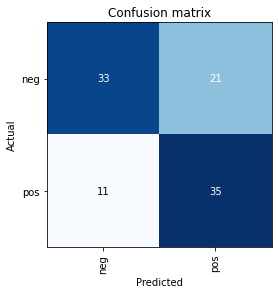

In [ ]:
# cuda
interp.plot_confusion_matrix()